Kaggle dataset of 5,863 pediatric chest x-rays with lables of Normal and Pneumonia

https://www.kaggle.com/paultimothymooney/undefined


In [1]:
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import os, os.path
from skimage import io
import copy

import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

from torchsummary import summary

%matplotlib inline


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Assume that we are on a CUDA machine, then this should print a CUDA device:
print(f'Working on device={device}')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Working on device=cuda


The images were uploaded to Google Drive.  So we need to mount a drive to this location to allow this notebook access to the images.

In [2]:
from google.colab import drive
drive.mount('/content/drive')
root_path = "drive/My Drive/data/chest_xray/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Directory Structure
We are given 3 folders, "train", "val" and "test".  
Each of these folders contains subfolders with "Normal" and "Pneumonia"

The validation folder will not be used since it only contains 16 minages.

So we will randomly split the training folder into train and validate.

In [0]:
train_data_path = root_path + "train/"
val_data_path = root_path + "val/"
test_data_path = root_path + "test/"

train_normal_path = train_data_path + "NORMAL/"
train_pneumonia_path = train_data_path + "PNEUMONIA/"

val_normal_path = val_data_path + "NORMAL/"
val_pneumonia_path = val_data_path + "PNEUMONIA/"

test_normal_path = test_data_path + "NORMAL/"
test_pneumonia_path = test_data_path + "PNEUMONIA/"

In [4]:
train_normal_dir = os.listdir(train_normal_path)
train_pneumonia_dir = os.listdir(train_pneumonia_path)

val_normal_dir = os.listdir(val_normal_path)
val_pneumonia_dir = os.listdir(val_pneumonia_path)

test_normal_dir = os.listdir(test_normal_path)
test_pneumonia_dir = os.listdir(test_pneumonia_path)

print("Number of normal x-rays (train): ", len(train_normal_dir))
print("Number of pneumonia x-rays (train): ", len(train_pneumonia_dir))

print("Number of normal x-rays (val): ", len(val_normal_dir))
print("Number of pneumonia x-rays (val): ", len(val_pneumonia_dir))

print("Number of normal x-rays (test): ", len(test_normal_dir))
print("Number of pneumonia x-rays (test): ", len(test_pneumonia_dir))

Number of normal x-rays (train):  1360
Number of pneumonia x-rays (train):  3886
Number of normal x-rays (val):  8
Number of pneumonia x-rays (val):  8
Number of normal x-rays (test):  235
Number of pneumonia x-rays (test):  391


# Let's take a quick look at the images

These are randomly picked from the training images for each label

In [0]:
def plot_images(item_dir, top=10):
  dir = os.listdir(item_dir)
  all_files = [os.path.join(item_dir, file) for file in dir]
  top_files = np.random.choice(all_files, top)

  plt.figure(figsize = (15,15))
  for idx, img_path in enumerate(top_files):
    plt.subplot(5,5, idx+1)
    img = io.imread(img_path, as_gray=False)
    plt.imshow(img, cmap=plt.get_cmap('gray'))
  plt.tight_layout()

## Normal

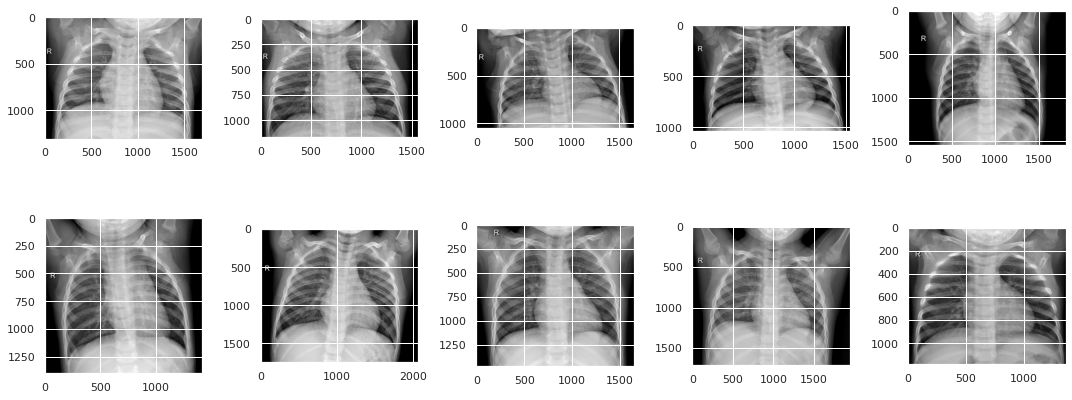

In [6]:
plot_images(train_normal_path)

## Pneumonia

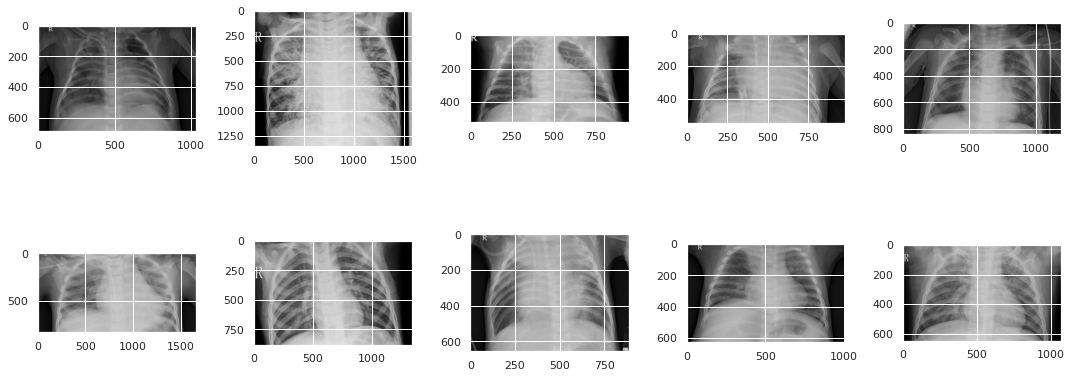

In [7]:
plot_images(train_pneumonia_path)

# Image Prep

We will need to prep the following transformations:
- Resize the images to a standard square shape
- Make sure the images are in gray scale
- Convert to pixels to PyTorch tensors

Since x-ray have strict procedural standards, we will not get images that are taken from different angles or way off center.  But there will be some variations.  If this child is in bed, has spinal diformaties or is not complient to holding a position, we will see some variation.  So, adding some small affine translations and rotations should help with generalizing the predictive value.

With this type of medical image, there could be leaks within the images.   Higher acuity patients may have their x-rays taken in bed, have EKG pads visible in the image or have other indicating factors.  These image features have a greater chance of being associated with pneumonia and bias the prediction.  But there is nothing to be done about this, but validation is key here to make sure these leaks don’t get out of hand.

We need to build 3 PyTorch objects:
-	Transform
-	Dataset
-	DataLoader

This needs to be done train, val and test.  

Since we were only given 16 images for validation, we will want to split the training images into 2 datasets.  80% towards train and 20% towards validation.  Ideally, we would want to use cross validation folds for this, but for now, we will just do a single split.




### Parameters needed for Transformation and Loader

In [0]:
hight = 224
width = 224
channels = 1
batch_size = 16
num_classes = 2

### Pixel Mean and SD for Image Normalization
Before we build or torchvision objects, we need to do a random sample of our training images to get the mean and standard deviation of the pixel distribution.

We need to use some the same preprocessing PyTorch will do such for the resize and gray scaling so are statistics are accurate.

So, we create throwaway transform, dataset, and loader object just for this calculation.  We will have to create new object for the real training data.



In [0]:
def get_image_statistics(dir, sample_size = 500):
  transform = transforms.Compose(
                                  [transforms.Resize(size=(hight,width), interpolation=2),
                                  transforms.Grayscale(1),
                                  transforms.ToTensor()])
  ds = torchvision.datasets.ImageFolder(root=dir, transform=transform)
  dss = torch.utils.data.Subset(ds, np.random.choice(len(ds), sample_size, replace=False))
  loader = torch.utils.data.DataLoader(dss, batch_size=sample_size)
  image_count = 0
  fst_moment = torch.empty(1)
  snd_moment = torch.empty(1)

  for images, _ in loader:

      b, c, h, w = images.shape
      nb_pixels = b * h * w
      sum_ = torch.sum(images, dim=[0, 2, 3])
      sum_of_square = torch.sum(images ** 2, dim=[0, 2, 3])
      fst_moment = (image_count * fst_moment + sum_) / (image_count + nb_pixels)
      snd_moment = (image_count * snd_moment + sum_of_square) / (image_count + nb_pixels)

      image_count += nb_pixels

  return fst_moment, torch.sqrt((snd_moment - fst_moment) ** 2)

In [10]:
train_img_mean, train_img_std = 0.4917, 0.1941
if train_img_mean == 0:
  train_img_mean, train_img_std = get_image_statistics(train_data_path)
train_img_mean, train_img_std 

(0.4917, 0.1941)

### Build the Actual Transformation Object

We could not do this before since we needed the mean and SD first

In [0]:
train_transform = transforms.Compose(
    [transforms.RandomAffine(degrees=8, translate=(.15,.15), shear=8),
     transforms.Resize(size=(hight,width), interpolation=2),
     transforms.Grayscale(1),
     transforms.ToTensor(),
     transforms.Normalize((train_img_mean,), (train_img_std,))])

val_transform = transforms.Compose(
    [transforms.Resize(size=(hight,width), interpolation=2),
     transforms.Grayscale(1),
     transforms.ToTensor(),
     transforms.Normalize((train_img_mean,), (train_img_std,))])

test_transform = transforms.Compose(
    [transforms.Resize(size=(hight,width), interpolation=2),
     transforms.Grayscale(1),
     transforms.ToTensor(),
     transforms.Normalize((train_img_mean,), (train_img_std,))])

classes = ('NORMAL', 'PNEUMONIA')

In [12]:
train_dataset = torchvision.datasets.ImageFolder(
        root=train_data_path,
        transform=train_transform
    )
print("train labels", train_dataset.classes)
'''
The Kaggle validation folder only has 16 images.  
Lets do an 80/20 split of the training dataset instead.
'''
train_length = int(len(train_dataset)*.8)
val_length = int(len(train_dataset) - train_length)
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_length, val_length])

#make sure validation DS uses the validation transformation
val_dataset = copy.deepcopy(val_dataset)
val_dataset.dataset.transform = val_transform

train_subset_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        num_workers=0,
        shuffle=True
    )

val_subset_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=batch_size,
        num_workers=0,
        shuffle=True
    )

test_dataset = torchvision.datasets.ImageFolder(
        root=test_data_path,
        transform=test_transform,
    )
print("test labels: ", test_dataset.classes)
test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        num_workers=0,
        shuffle=True
    )


train labels ['NORMAL', 'PNEUMONIA']
test labels:  ['NORMAL', 'PNEUMONIA']


# Build CNN

In [0]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)

        #Input image size = 224X224
 
        # 1st Convolution 512 filters each with 1 kernel (channel) with each kernel 5x5=25:  512*1*25 + 512(biases) = 13,312 trainable parameters
        # Padding: With strid=1, P = (Filter - 1)/2 = (5-1)/2 = 2.  
        # If the 5x5 moves across the image 224 times, the last position will hang off by 4 pixels, so pad 2 on each side to make it even
        # This keeps the output image 224x224
        #Note: Each batch norm will have 2 trainable parameters per input channel
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=512, kernel_size=5, stride=1, padding=2)
        self.batchnorm1 = nn.BatchNorm2d(512) # 1024 trainable parameters
        #relu
        #max pool 2x2 This will make image size 112/112

        # 2nd Convolution 256 filters each with 512 kernels (input channels) with each kernel 3x3=9:  256*512*9 + 256 = 1,179,904 trainable parameters
        # Padding: With strid=1, P = (Filter - 1)/2 = (3-1)/2 = 1
        self.conv2 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(256) # 512 trainable parameters
        #relu
        #max pool 2x2 This will make image size 56/56

        # 3rd Convolution 64 filters each with 256 kernels (input channels) with each kernel 3x3=9:  64*256*9 + 64 = 147,520 trainable parameters
        # Padding: With strid=1, P = (Filter - 1)/2 = (3-1)/2 = 1
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(64) # 128 trainable parameters
        #relu
        #max pool 2x2 This will make image size 28/28

        # Fully Connected Vector: unraveling this last 28x28 image gives use 784 values for our vector
        #  But we need to do this for each output channel so 64x28x28 = 50,176 values for our flattened vector
        self.flattened_length_ = 64*28*28

        # FC1 This is where we can really accumulate trainable parameters
        # Linear: for each filter (output channel), will will have over 50k slopes and 1 y-intercept
        # So, ~ 50k params for each output channel
        # Lets target around 50 million params, so ~1,000 output channels.  We will use 1024 to keep with our powers of 2 convention
        # m=1024x(64*28*28), b=1014 = 1024x64x28x28 + 1024 = 51,381,248 trainable parameters
        self.fc1 = nn.Linear(self.flattened_length_, 1024)

        # FC2 2 Let's shoot for a reuction to 1/2 the size of the input vector (512 out)
        # m=512x(1024), b=512 = 524,800 trainable parameters
        self.fc2 = nn.Linear(1024, 512)
        
        # FC3 2 output channels, this need to match the number of labels we have (binary in this case)
        # 2x1014 slopes and 2 y-intercepts = 2050 trainable parameters
        # The softmax (or log softmax for Cross Entrypy) is done in the loss function to detmine the probability for each class
        self.fc3 = nn.Linear(512, 2)

        # Regularization:  Dropout is kind of like ensemble component of Random Forest
        #  RF will randomly pick some features for each tree in the ensemble
        #  This makes sure that some of the less impactful features get a chance to contribute
        #  Here, we will randomly zero out 20% of the flattened vector's weights
        #  This will be done with each mini-batch
        #  The goal is to prevent overfitting or memorizing the trainging data
        self.dropout = nn.Dropout(0.5) 

         
    def forward(self, x):

        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = F.relu(x)
        x = self.pool(x)
       
        x = x.view(-1, self.flattened_length_)
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
      
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.fc3(x)
        return x

In [14]:
net = ConvNet()
net = nn.DataParallel(net)
net.to(device)


learning_rate = 1e-4
num_epochs = 30

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr=learning_rate)#, weight_decay=0.9)

summary(net, (channels, hight, width))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 512, 224, 224]          13,312
       BatchNorm2d-2        [-1, 512, 224, 224]           1,024
         MaxPool2d-3        [-1, 512, 112, 112]               0
            Conv2d-4        [-1, 256, 112, 112]       1,179,904
       BatchNorm2d-5        [-1, 256, 112, 112]             512
         MaxPool2d-6          [-1, 256, 56, 56]               0
            Conv2d-7           [-1, 64, 56, 56]         147,520
       BatchNorm2d-8           [-1, 64, 56, 56]             128
         MaxPool2d-9           [-1, 64, 28, 28]               0
           Linear-10                 [-1, 1024]      51,381,248
          Dropout-11                 [-1, 1024]               0
           Linear-12                  [-1, 512]         524,800
          Dropout-13                  [-1, 512]               0
           Linear-14                   

In [15]:
train_accuracy_index = []
train_acc, train_total, train_correct = 0, 0, 0
val_accuracy_index = []
val_acc, val_total, val_correct = 0, 0, 0
test_accuracy_index = []
test_acc, test_total, test_correct = 0, 0, 0
losses_index = []
for epoch in range(num_epochs):  # loop over the dataset multiple times
    start_time = datetime.now()
    net.train()
    running_loss = 0.0
    epoch_loss = 0
    for i, data in enumerate(train_subset_loader, 0):
        # get the inputs
        inputs, labels = data
        # move data to device GPU OR CPU
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        
        #Get Training Accuracty
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        train_acc = train_correct/train_total
        train_accuracy_index.append(train_acc)

        #loss, back prop and update params
        loss = criterion(outputs, labels)#.float())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss = epoch_loss / len(train_subset_loader)
    time_elapsed = datetime.now() - start_time
    losses_index.append(epoch_loss)
    
    # Validation set
    net.eval()
    with torch.no_grad():
      for data in val_subset_loader:
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = net(inputs)
          _, predicted = torch.max(outputs.data, 1)
          val_total += labels.size(0)
          val_correct += (predicted == labels).sum().item()
          val_acc = val_correct/val_total
      val_accuracy_index.append(val_acc)

      for data in test_loader:
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = net(inputs)
          _, predicted = torch.max(outputs.data, 1)
          test_total += labels.size(0)
          test_correct += (predicted == labels).sum().item()
          test_acc = test_correct/test_total
      test_accuracy_index.append(test_acc)
    
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Epoch Loss: {epoch_loss:.4f} Training Accuracy: {train_acc:.4f}  Validation Accuracy: {val_acc:.4f} Test Accuracy: {test_acc:.4f} - (time={time_elapsed})')

Epoch [1/30], Epoch Loss: 0.4184 Training Accuracy: 0.8170  Validation Accuracy: 0.9190 Test Accuracy: 0.7492 - (time=0:02:50.529326)
Epoch [2/30], Epoch Loss: 0.2554 Training Accuracy: 0.8550  Validation Accuracy: 0.9362 Test Accuracy: 0.7612 - (time=0:02:49.475461)
Epoch [3/30], Epoch Loss: 0.2157 Training Accuracy: 0.8763  Validation Accuracy: 0.9416 Test Accuracy: 0.7524 - (time=0:02:52.234098)
Epoch [4/30], Epoch Loss: 0.1760 Training Accuracy: 0.8894  Validation Accuracy: 0.9493 Test Accuracy: 0.7576 - (time=0:02:49.343709)
Epoch [5/30], Epoch Loss: 0.1755 Training Accuracy: 0.8987  Validation Accuracy: 0.9507 Test Accuracy: 0.7725 - (time=0:02:49.354608)
Epoch [6/30], Epoch Loss: 0.1583 Training Accuracy: 0.9054  Validation Accuracy: 0.9527 Test Accuracy: 0.7812 - (time=0:02:49.462575)
Epoch [7/30], Epoch Loss: 0.1619 Training Accuracy: 0.9096  Validation Accuracy: 0.9532 Test Accuracy: 0.7887 - (time=0:02:46.268089)
Epoch [8/30], Epoch Loss: 0.1419 Training Accuracy: 0.9143  Va